> Code to accompany **Chapter 7: Attack Patterns on Real World Systems**

# Re-using Adversarial Patches Across Images


The patch used in this notebook is taken from the paper [Adversarial Patch by Brown et al.](https://arxiv.org/abs/1712.09665). 

In this notebook, we'll apply it digitally to the image, but the authors proved that such patches work in the physical world. To see adversarial patches in action, take a look at this video:
[Adversarial Patch on YouTube](https://www.youtube.com/watch?v=i1sp4X57TL4&feature=youtu.be).
 
Example code for creating adversarial patches is [here](https://github.com/tensorflow/cleverhans/tree/master/examples/adversarial_patch)


## Import the pre-trained ResNet50 Model

The following code gets the pre-trained ImageNet model.

In [66]:
# Import the model
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet50 import ResNet50

# Get the ResNet50 network using the imagenet trained weights
model = ResNet50(weights='imagenet', include_top=True)

Import a few libraries.

In this example, we'll use the PIL helper library to manipulate the images.

In [67]:
from PIL import Image, ImageOps, ImageDraw

# NumPy for manipulating images as multi-dimensional arrays
import numpy as np

# PyPlot for plotting
import matplotlib.pyplot as plt

## Helper utility to print the ResNet50 classifications for an image

This is based on the code from chapter 4. Here's the [Jupyter notebook on GitHub](https://github.com/katywarr/strengthening-dnns/blob/master/chapter04/resnet50_classifier.ipynb) and here's the [relative path to the Jypyter notebook](../chapter04/resnet50_classifier.ipynb) if you want to run it.

In [68]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions

def display_classification(model, image):
    image_for_resnet = preprocess_input(image)
    image_for_resnet_list = np.expand_dims(image_for_resnet, 0)

    predictions = model.predict(image_for_resnet_list)
    decoded_predictions = decode_predictions(predictions, top=3)

    predictions_for_image = decoded_predictions[0]
    for pred in predictions_for_image:
        print(pred[1],' : ', pred[2])

## Select our base image and display its classification

There are several images in the image folder to try. Or, of course, you can try experiment with your own images.

koala  :  0.9999851
indri  :  7.1033173e-06
wombat  :  3.869358e-06


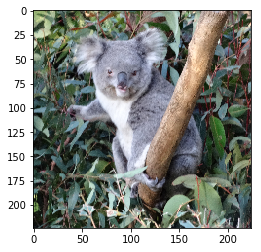

In [69]:
base_image = Image.open('../images/koala.jpg')
base_image = base_image.resize((224, 224))
plt.imshow(base_image)
display_classification(model, np.asarray(base_image))

## Select the patch and display its classification

The patch is also available online here:


toaster  :  1.0
cassette_player  :  3.727074e-09
digital_clock  :  1.8297661e-09


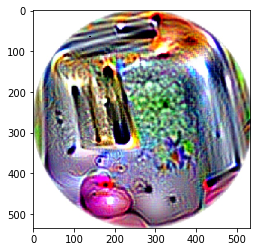

In [70]:
original_patch = Image.open('../images/adversarial_patch_toaster.jpg')
plt.imshow(original_patch)
# Note that we need to resize the patch for ResNet50
display_classification(model, np.asarray(original_patch.resize((224, 224))))

It's a near-perfect toaster in the eyes of ResNet50.

## Resize the patch and place it on the image

Begin by specifying the patch size and its position.

In [71]:
patch_width_proportion = 0.40
patch_position_from_top = 125
patch_position_from_left = 0

Resize the patch according to the specifications.

In [72]:
patch_diameter = int(224 * patch_width_proportion)
patch = original_patch.copy().resize((patch_diameter, patch_diameter))

Remember that as the patch is reduced in resolution, it will lose data and therefore may be less adversarial.
Let's just check the scores from ResNet50.

In [73]:
display_classification(model, np.asarray(patch.resize((224, 224))))

toaster  :  1.0
piggy_bank  :  3.2838687e-11
soap_dispenser  :  3.2731318e-11


Now we need to create a 'mask' to lay over the patch so we don't get white-space around the toaster circle.

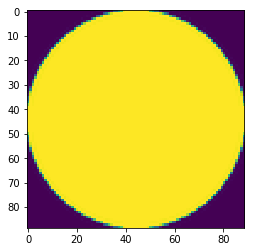

In [74]:
bigsize = (patch.size[0] * 3, patch.size[1] * 3)
mask = Image.new('L', bigsize, 0)
draw = ImageDraw.Draw(mask) 
draw.ellipse((0, 0) + bigsize, fill=255)
mask = mask.resize(patch.size, Image.ANTIALIAS)
plt.imshow(mask)

Use this mask when layering the patch on the final image.

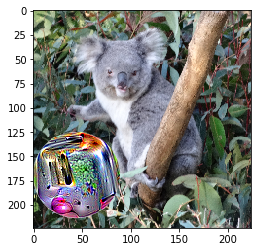

In [75]:
patched_base_image = base_image.copy()
patch.putalpha(mask)
output = ImageOps.fit(patch, mask.size, centering=(0.5, 0.5))
output.putalpha(mask)
patched_base_image.paste(patch, (patch_position_from_left, patch_position_from_top), patch)
plt.imshow(patched_base_image)

Finally, let's see what ResNet50 makes of this.

In [76]:
display_classification(model, np.asarray(patched_base_image))

toaster  :  0.97956973
koala  :  0.0204213
parking_meter  :  7.539606e-07


If you want to experiment, re-run the previous cells to:

* Change the size and position of the patch.

* Try with different images.